In [17]:
import pysam
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import pandas as pd
import seaborn as sns

Show callable genome via alignment depth

In [7]:

def plot_genome_coverage_vs_depth(
    bam_path,
    max_depth=50,
    min_mapq=0,
    title=None
):
    """
    Plot percent of genome covered as a function of minimum depth.

    Parameters
    ----------
    bam_path : str
        Path to BAM or SAM file (SAM must be indexed if large).
    max_depth : int
        Maximum depth threshold to plot.
    min_mapq : int
        Minimum mapping quality to include reads.
    title : str or None
        Optional plot title.
    """

    bam = pysam.AlignmentFile(bam_path, "rb" if bam_path.endswith(".bam") else "r")

    # Get reference lengths
    ref_lengths = dict(zip(bam.references, bam.lengths))
    genome_size = sum(ref_lengths.values())

    # Initialize depth array (sparse via dict to save memory)
    depth_counts = np.zeros(genome_size, dtype=np.uint16)

    offset = 0
    for ref in bam.references:
        length = ref_lengths[ref]

        # Count depth per position
        for pileupcolumn in bam.pileup(
            ref,
            stepper="samtools",
            min_mapping_quality=min_mapq,
            truncate=True
        ):
            pos = offset + pileupcolumn.reference_pos
            depth_counts[pos] = pileupcolumn.nsegments

        offset += length

    bam.close()

    # Compute percent genome covered at >= depth
    depths = np.arange(1, max_depth + 1)
    coverage_pct = [
        100 * np.sum(depth_counts >= d) / genome_size
        for d in depths
    ]

    # Plot
    #plt.figure(figsize=(6, 4))
    plt.plot(depths, coverage_pct)
    plt.xlabel("Minimum depth of coverage")
    plt.ylabel("Percent of genome covered")
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()


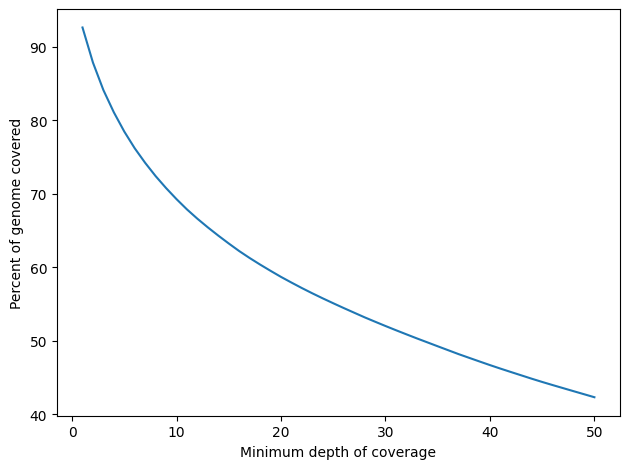

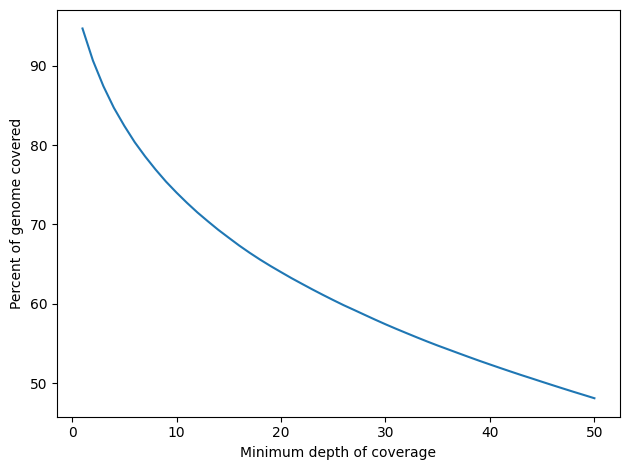

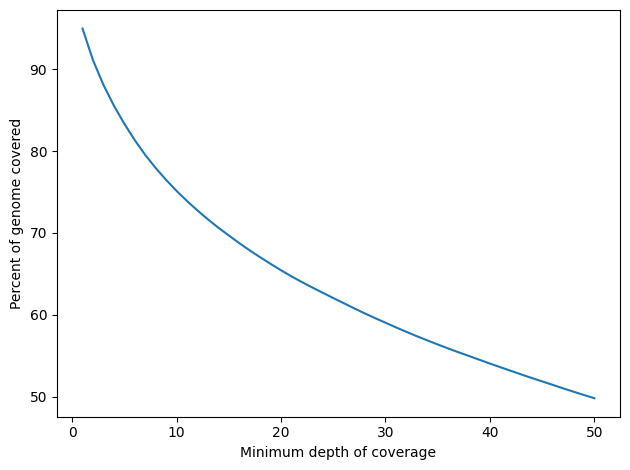

In [8]:
plot_genome_coverage_vs_depth('../aln/T4-NDC90min-A.bam')
plot_genome_coverage_vs_depth('../aln/T4-NDC90min-B.bam')
plot_genome_coverage_vs_depth('../aln/T4-NDC90min-C.bam')


In [15]:
def genome_coverage_at_depth(
    bam_path,
    depth_threshold=5,
    min_mapq=15
):
    """
    Return fraction and percent of genome covered at >= depth_threshold.

    Requires samtools in PATH.
    """

    cmd = [
        "samtools", "depth",
        "-q", str(min_mapq),
        bam_path
    ]
    
    bam = pysam.AlignmentFile(bam_path, "rb" if bam_path.endswith(".bam") else "r")
    # Get reference lengths
    ref_lengths = dict(zip(bam.references, bam.lengths))
    genome_size = sum(ref_lengths.values())

    covered = 0
    total = 0

    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, text=True)

    for line in proc.stdout:
        total += 1
        depth = int(line.rstrip().split()[2])
        if depth >= depth_threshold:
            covered += 1

    proc.wait()

    frac = covered / genome_size
    return frac

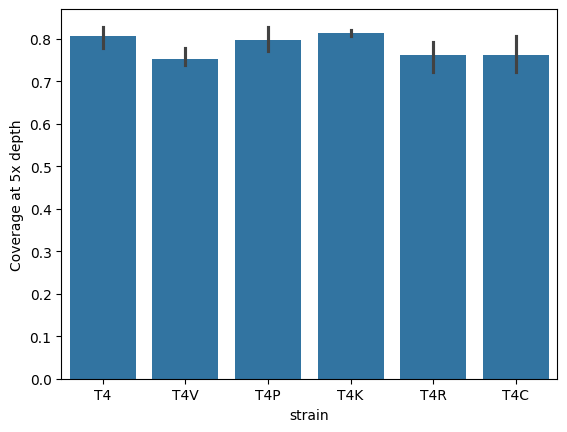

In [34]:
samples_list = ["T4-NDC90min-A",
  "T4-NDC90min-B",
  "T4-NDC90min-C",
                
  "T4V-024V90MIN-A",
  "T4V-024V90MIN-B",
  "T4V-024V90MIN-C",

  "T4P-004PEN120min-A",
  "T4P-004PEN120min-B",
  "T4P-004PEN120min-C",
                
  "T4K-1KAN120min-a",
  "T4K-1KAN120min-b",
  "T4K-1KAN120min-c",

  "T4R-0035RIF120min-A",
  "T4R-0035RIF120min-B",
  "T4R-0035RIF120min-C",

  "T4C-NDC120min-a",
  "T4C-NDC120min-b",
  "T4C-NDC120min-c",
               ]

samples_df = pd.DataFrame({'sample': samples_list, 
                          })
samples_df['strain'] = samples_df.apply(lambda x: x['sample'].split('-')[0], axis=1)
samples_df['5x_cov'] = samples_df.apply(lambda x: genome_coverage_at_depth('../aln/'+x['sample']+'.bam'), axis=1)
sns.barplot(data = samples_df, y='5x_cov', x='strain')
plt.ylabel('Coverage at 5x depth')
plt.savefig('data/figures/coverage.png')

# Allele frequencies

In [24]:
def extract_allele_depths(vcf_path, chrom, pos):
    """
    Extract allele depth information for a single position across all samples.
    
    pos is 1-based (VCF convention).
    """
    vcf = pysam.VariantFile(vcf_path)

    records = []
    for record in vcf.fetch(chrom, pos - 1, pos):
        if record.pos != pos:
            continue

        ref = record.ref
        alts = record.alts

        for sample in record.samples:
            sample_data = record.samples[sample]

            # AD = [ref_depth, alt1_depth, alt2_depth, ...]
            ad = sample_data.get("AD", None)
            dp = sample_data.get("DP", None)

            if ad is not None and len(ad) > 1:
                alt_depth = sum(ad[1:])
                ref_depth = ad[0]
                af = alt_depth / (ref_depth + alt_depth) if (ref_depth + alt_depth) > 0 else 0
            else:
                ref_depth = None
                alt_depth = None
                af = None

            records.append({
                "sample": sample,
                "position": pos,
                "ref": ref,
                "alt": ",".join(alts),
                "ref_depth": ref_depth,
                "alt_depth": alt_depth,
                "total_depth": dp,
                "alt_allele_fraction": af
            })

    return pd.DataFrame(records)

In [32]:
#murE
chrom = 'NZ_CP155539.1'
pos = 713638

vcf_samples = [
    'data/vars/variant_calling_VNC/T4-NDC90min-A_calls.filtered.vcf.gz', # WT strain, confirm mutation is absent
    'data/vars/variant_calling_VNC/T4-NDC90min-B_calls.filtered.vcf.gz',
    'data/vars/variant_calling_VNC/T4-NDC90min-C_calls.filtered.vcf.gz',
    
    'data/vars/variant_calling_CIP/T4C-NDC120min-A_calls.filtered.vcf.gz',
    'data/vars/variant_calling_CIP/T4C-NDC120min-B_calls.filtered.vcf.gz',
    'data/vars/variant_calling_CIP/T4C-NDC120min-C_calls.filtered.vcf.gz',
    
    'data/vars/variant_calling_KAN/T4K-1KAN120min-a_calls.filtered.vcf.gz',
    'data/vars/variant_calling_KAN/T4K-1KAN120min-b_calls.filtered.vcf.gz',
    'data/vars/variant_calling_KAN/T4K-1KAN120min-c_calls.filtered.vcf.gz',

    'data/vars/variant_calling_PEN/T4P-004PEN120min-a_calls.filtered.vcf.gz',
    'data/vars/variant_calling_PEN/T4P-004PEN120min-b_calls.filtered.vcf.gz',
    'data/vars/variant_calling_PEN/T4P-004PEN120min-c_calls.filtered.vcf.gz',

    'data/vars/variant_calling_RIF/T4R-0035RIF120min-A_calls.filtered.vcf.gz',
    'data/vars/variant_calling_RIF/T4R-0035RIF120min-B_calls.filtered.vcf.gz',
    'data/vars/variant_calling_RIF/T4R-0035RIF120min-C_calls.filtered.vcf.gz',
    
    'data/vars/variant_calling_VNC/T4V-024V90min-A_calls.filtered.vcf.gz',
    'data/vars/variant_calling_VNC/T4V-024V90min-B_calls.filtered.vcf.gz',
    'data/vars/variant_calling_VNC/T4V-024V90min-C_calls.filtered.vcf.gz',
]

allele_depths = pd.DataFrame()
for vcf in vcf_samples:
    sample_allele_depth = extract_allele_depths(vcf, chrom, pos)
    allele_depths = pd.concat([allele_depths, sample_allele_depth])

allele_depths

,sample,position,ref,alt,ref_depth,alt_depth,total_depth,alt_allele_fraction
0,aln/T4C-NDC120min-a.bam,713638,C,A,24,60,84,0.714286
0,aln/T4C-NDC120min-c.bam,713638,C,A,22,64,87,0.744186
0,aln/T4K-1KAN120min-a.bam,713638,C,A,3,32,35,0.914286
0,aln/T4K-1KAN120min-b.bam,713638,C,A,2,38,40,0.950000
0,aln/T4K-1KAN120min-c.bam,713638,C,A,8,66,74,0.891892
0,aln/T4P-004PEN120min-A.bam,713638,C,A,0,57,57,1.000000
0,aln/T4P-004PEN120min-B.bam,713638,C,A,0,77,77,1.000000
0,aln/T4P-004PEN120min-C.bam,713638,C,A,0,81,81,1.000000


In [33]:
allele_depths.to_csv('data/allele_depths.csv', index=None)